In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.regression.linear_model import OLS
from statsmodels.multivariate.pca import PCA
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order

from sklearn.metrics import mean_squared_error

# Visualisation et tests statistiques

In [2]:
unrate = pd.read_csv('UNRATE.csv')

In [3]:
unrate['DATE']= pd.to_datetime(unrate['DATE'])
unrate.set_index("DATE", inplace=True)
unrate.index.freq = unrate.index.inferred_freq
unrate_nocovid = unrate.drop(unrate.index[864:881])
testset = unrate.iloc[803:803+61]

In [4]:
unrate.iloc[155:].describe()

,UNRATE_PCH
count,729.000000
mean,0.167358
std,9.348985
min,-17.647060
25%,-2.040820
50%,0.000000
75%,1.785710
max,236.363640


In [5]:
unrate_nocovid.iloc[155:].describe()

,UNRATE_PCH
count,712.000000
mean,-0.075495
std,2.927288
min,-8.510640
25%,-2.000000
50%,0.000000
75%,1.818180
max,12.500000


In [6]:
unrate.iloc[155:803].mean()

UNRATE_PCH    0.016495
dtype: float64

In [7]:
unrate.iloc[155:803].std()

UNRATE_PCH    2.908475
dtype: float64

In [8]:
unrate.iloc[155:].mean()

UNRATE_PCH    0.167358
dtype: float64

In [9]:
unrate.iloc[155:].std()

UNRATE_PCH    9.348985
dtype: float64

In [10]:
unrate_nocovid.iloc[155:].mean()

UNRATE_PCH   -0.075495
dtype: float64

In [11]:
unrate_nocovid.iloc[155:].std()

UNRATE_PCH    2.927288
dtype: float64

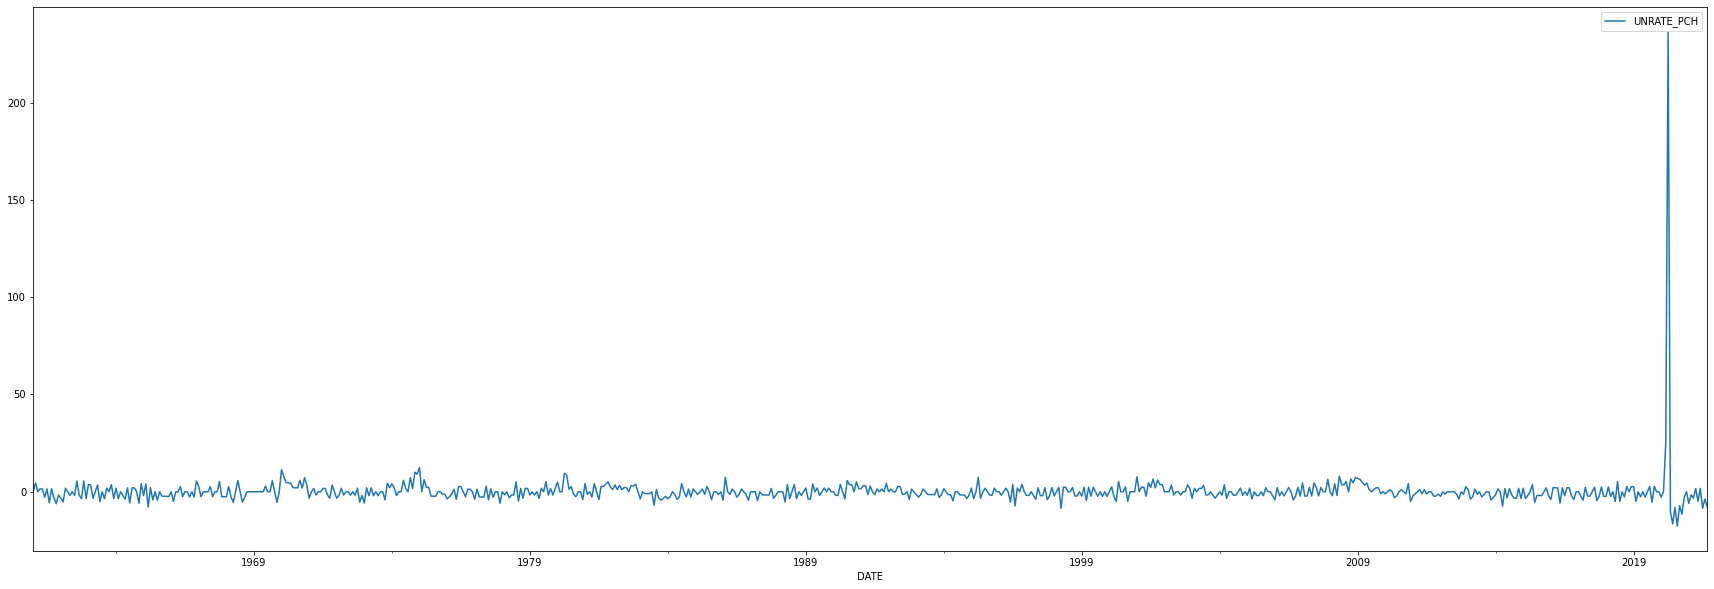

In [12]:
unrate.iloc[155:].plot(figsize=(30,10))

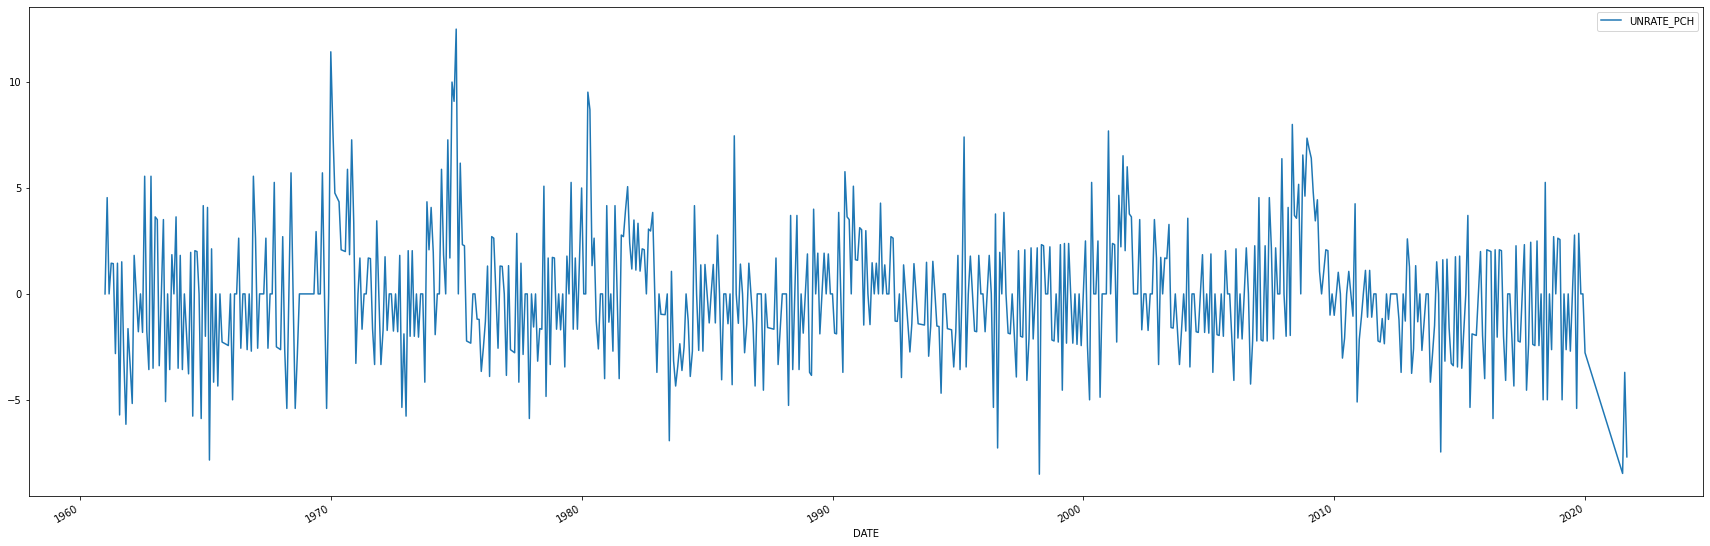

In [13]:
unrate_nocovid.iloc[155:].plot(figsize=(30,10))

## Moyenne Historique

In [14]:
prediction=[]

for h in range(12):

    for i in range(61):
    
        endog = unrate.iloc[155:803+i-h]
        
        mean = endog.mean()
    
        prediction.append(mean)

In [15]:
mse_HA = [mean_squared_error(testset,prediction[i*61:(i*61)+61]) for i in range(12)]
mse_HA

[7.834188686875837,
 7.827285626193633,
 7.828452955216857,
 7.827021024960569,
 7.834063255852091,
 7.831621948615431,
 7.834757884180301,
 7.84018537781446,
 7.835553059352381,
 7.835481213092504,
 7.844786678272537,
 7.848708446826405]

In [16]:
hlist = [i for i in range(1,13)]

In [17]:
mse_HAdf = pd.DataFrame()
mse_HAdf['MSE'] =mse_HA
mse_HAdf.index = hlist
mse_HAdf.index.names = ['h']
mse_HAdf

,MSE
h,
1,7.834189
2,7.827286
3,7.828453
4,7.827021
5,7.834063
6,7.831622
7,7.834758
8,7.840185
9,7.835553


In [21]:
prediction_withcovid=[]
prediction_nocovid=[]

for i in range(13):
    
        endog = unrate.iloc[155:]
        endog2 = unrate_nocovid.iloc[155:]
        mean = endog['UNRATE_PCH'].mean()
        mean2 = endog2['UNRATE_PCH'].mean()
        
        prediction_withcovid.append(mean)
        prediction_nocovid.append(mean2)

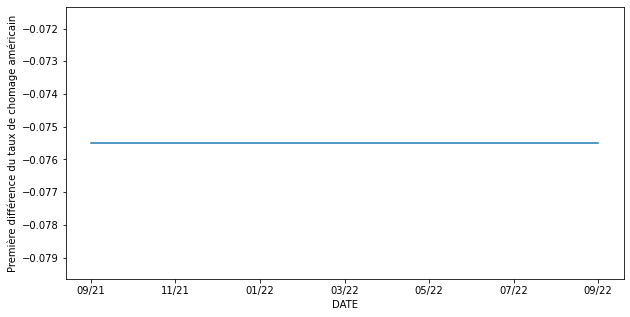

In [22]:
prediction_index = ['09/21','10/21','11/21','12/21','01/22','02/22','03/22','04/22','05/22',
                    '06/22','07/22','08/22','09/22']


prediction_withcovidS = pd.Series(prediction_withcovid)
prediction_nocovidS = pd.Series(prediction_nocovid)

prediction_withcovidS.index = prediction_index
prediction_nocovidS.index = prediction_index


HA_nocovid = prediction_nocovidS.plot(figsize=(10,5),xlabel='DATE',ylabel="Première différence du taux de chomage américain")

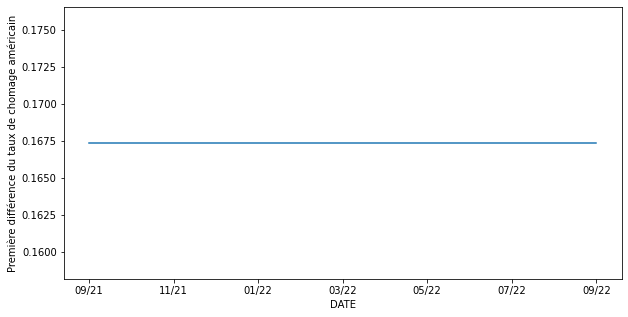

In [23]:
HA_withcovid = prediction_withcovidS.plot(figsize=(10,5),xlabel='DATE',ylabel="Première différence du taux de chomage américain")

In [24]:
## moyenne 5 fois plsu elever

## Benchmark

In [25]:
res = []
prediction=[]
resindex = 0

for h in range(12):
    for i in range(61):

        endog = unrate.iloc[155:803+i] 
        
        
        model = AutoReg(endog, lags=[h+1])

        v = model.fit()

        res.append(v)
        
        prediction.append(res[resindex].predict(803+i-155,803+i-155))
        
        resindex +=1

In [26]:
mse_AR1 = [mean_squared_error(testset,prediction[i*61:(i*61)+61]) for i in range(12)]
mse_AR1

[8.167672921716107,
 8.042665018726868,
 8.332424265802656,
 7.203732537796952,
 8.368665256622924,
 7.713158849816331,
 7.543983801117877,
 8.519415192076677,
 7.932920355825412,
 7.566259732764499,
 7.664653289081456,
 7.779090682851456]

In [27]:
mse_benchmark = mse_AR1[0]

In [28]:
mse_HA_relative = [i/mse_benchmark for i in mse_HA]
mse_HA_relative

[0.9591702265704585,
 0.9583250579712298,
 0.9584679786090189,
 0.9582926618119321,
 0.959154869561804,
 0.9588559708105856,
 0.9592399156128478,
 0.9599044247926569,
 0.9593372720055071,
 0.9593284755881475,
 0.9604677799247954,
 0.9609479373198645]

In [29]:
mse_HAdf = pd.DataFrame()
mse_HAdf['MSE moyenne historique /MSE Benchmark'] =mse_HA_relative
mse_HAdf.index = hlist
mse_HAdf.index.names = ['h']
mse_HAdf

,MSE moyenne historique /MSE Benchmark
h,
1,0.959170
2,0.958325
3,0.958468
4,0.958293
5,0.959155
6,0.958856
7,0.959240
8,0.959904
9,0.959337


## Autoregressif

In [30]:
select = ar_select_order(unrate.iloc[155:803],maxlag=12)

In [31]:
print(select.ar_lags)

[1, 2, 3, 4, 5]


In [32]:
res = []
prediction=[]
resindex = 0

for h in range(12):
    for i in range(61):

        endog = unrate.iloc[155:803+i] 
        
        
        model = AutoReg(endog, lags=[h+1,h+2,h+3,h+4])

        v = model.fit()

        res.append(v)
        
        prediction.append(res[resindex].predict(803+i-155,803+i-155))
        
        resindex +=1
    

In [33]:
prediction

[2015-01-01   -0.775529
 Freq: MS, dtype: float64,
 2015-02-01   -0.846628
 Freq: MS, dtype: float64,
 2015-03-01    0.016714
 Freq: MS, dtype: float64,
 2015-04-01   -0.834488
 Freq: MS, dtype: float64,
 2015-05-01   -0.69779
 Freq: MS, dtype: float64,
 2015-06-01   -0.906171
 Freq: MS, dtype: float64,
 2015-07-01    0.450703
 Freq: MS, dtype: float64,
 2015-08-01   -0.271744
 Freq: MS, dtype: float64,
 2015-09-01   -0.694089
 Freq: MS, dtype: float64,
 2015-10-01   -1.522749
 Freq: MS, dtype: float64,
 2015-11-01   -1.004014
 Freq: MS, dtype: float64,
 2015-12-01   -0.67753
 Freq: MS, dtype: float64,
 2016-01-01    0.065775
 Freq: MS, dtype: float64,
 2016-02-01    0.036781
 Freq: MS, dtype: float64,
 2016-03-01   -0.777402
 Freq: MS, dtype: float64,
 2016-04-01   -0.694556
 Freq: MS, dtype: float64,
 2016-05-01    0.069406
 Freq: MS, dtype: float64,
 2016-06-01    1.099226
 Freq: MS, dtype: float64,
 2016-07-01   -0.367197
 Freq: MS, dtype: float64,
 2016-08-01   -0.320391
 Freq: MS

In [34]:
mse_AR = [mean_squared_error(testset,prediction[i*61:(i*61)+61]) for i in range(12)]
mse_AR

[7.489851487048856,
 7.706251239092301,
 7.590811942487111,
 7.371037817445943,
 8.234882351701668,
 7.978354532294415,
 8.29178242421606,
 8.230153723530186,
 7.368547329874066,
 7.348976453831973,
 7.963207739369708,
 8.076777608190172]

In [35]:
mse_AR_relative = [i/mse_benchmark for i in mse_AR]
mse_AR_relative

[0.9170116823771104,
 0.94350634666124,
 0.9293726640674793,
 0.902464862157729,
 1.0082287122206943,
 0.9768210123940768,
 1.0151952096624697,
 1.007649767860801,
 0.9021599420665664,
 0.8997638035054766,
 0.9749665315560361,
 0.9888713328267267]

In [36]:
mse_HAdf = pd.DataFrame()
mse_HAdf['MSE AR /MSE Benchmark'] =mse_AR_relative
mse_HAdf.index = hlist
mse_HAdf.index.names = ['h']
mse_HAdf

,MSE AR /MSE Benchmark
h,
1,0.917012
2,0.943506
3,0.929373
4,0.902465
5,1.008229
6,0.976821
7,1.015195
8,1.007650
9,0.902160


In [37]:
## h4 est le best, mais tout est proche donc statistiquement?

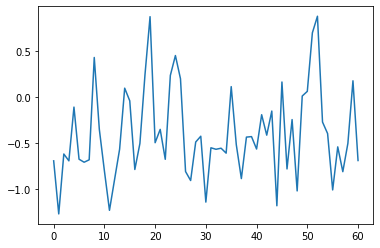

In [38]:
fig_size=(10,3)
plt.plot(prediction[61*3:61*4])

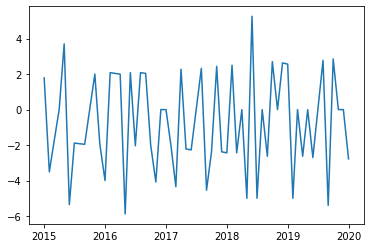

In [39]:
plt.plot(testset)

In [40]:
prediction_withcovid=[]
prediction_nocovid=[]

endog = unrate.iloc[155:]
endog2 = unrate_nocovid.iloc[155:]



model = AutoReg(endog, lags=[4,5,6,7])
model2 = AutoReg(endog2, lags=[4,5,6,7])

pred = model.fit()
pred2 = model2.fit()

predwcovid = pred.predict(728,728+12,dynamic=True)
prednocovid = pred2.predict(711,711+12,dynamic=True)
prednocovid.index = predwcovid.index

#predwcovid = pred.forecast(13)

/Users/guilou/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/guilou/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/guilou/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and NumericIndex with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


In [41]:
pred2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             UNRATE_PCH   No. Observations:                  712
Model:              Restr. AutoReg(7)   Log Likelihood               -1729.140
Method:               Conditional MLE   S.D. of innovations              2.812
Date:                Wed, 17 Nov 2021   AIC                           3470.279
Time:                        10:04:10   BIC                           3497.629
Sample:                             7   HQIC                          3480.848
                                  712                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0621      0.106     -0.586      0.558      -0.270       0.146
UNRATE_PCH.L4     0.1767      0.038      4.645      0.000       0.102       0.251
UNRATE_PCH.L5     0.1469      0.037      3.922      0.000       0.073       0.220
UNRATE_PCH.L6     0.1027      0.037      2.748      0.006       0.029       0.176
UNRATE_PCH.L7     0.0378      0.038      0.995      0.320      -0.037       0.112
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1633           -0.0000j            1.1633           -0.0000
AR.2            0.5042           -1.2804j            1.3761           -0.1903
AR.3            0.5042           +1.2804j            1.3761            0.1903
AR.4           -0.6154           -1.7303j            1.8365           -0.3044
AR.5           -0.6154           +1.7303j            1.8365            0.3044
AR.6           -1.8292           -0.4644j            1.8872           -0.4604
AR.7           -1.8292           +0.4644j            1.8872            0.4604
-----------------------------------------------------------------------------
"""

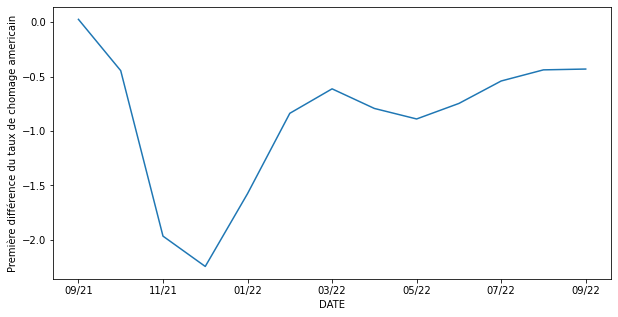

In [42]:
prediction_index = ['09/21','10/21','11/21','12/21','01/22','02/22','03/22','04/22','05/22',
                    '06/22','07/22','08/22','09/22']


prediction_withcovidS = pd.Series(predwcovid)
prediction_nocovidS = pd.Series(prednocovid)

prediction_withcovidS.index = prediction_index
prediction_nocovidS.index = prediction_index


AR_nocovid = prediction_nocovidS.plot(figsize=(10,5),xlabel='DATE',ylabel="Première différence du taux de chomage americain")

In [43]:
pred.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             UNRATE_PCH   No. Observations:                  729
Model:              Restr. AutoReg(7)   Log Likelihood               -2640.169
Method:               Conditional MLE   S.D. of innovations              9.373
Date:                Wed, 17 Nov 2021   AIC                           5292.339
Time:                        10:04:12   BIC                           5319.831
Sample:                    08-01-1961   HQIC                          5302.951
                         - 09-01-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1782      0.349      0.511      0.610      -0.506       0.862
UNRATE_PCH.L4    -0.0422      0.037     -1.130      0.258      -0.115       0.031
UNRATE_PCH.L5    -0.0084      0.037     -0.223      0.823      -0.082       0.065
UNRATE_PCH.L6    -0.0191      0.037     -0.511      0.609      -0.093       0.054
UNRATE_PCH.L7    -0.0210      0.037     -0.563      0.574      -0.094       0.052
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3798           -0.7979j            1.5939           -0.0834
AR.2            1.3798           +0.7979j            1.5939            0.0834
AR.3            0.3222           -1.7542j            1.7836           -0.2211
AR.4            0.3222           +1.7542j            1.7836            0.2211
AR.5           -1.1633           -1.2677j            1.7206           -0.3682
AR.6           -1.1633           +1.2677j            1.7206            0.3682
AR.7           -1.9885           -0.0000j            1.9885           -0.5000
-----------------------------------------------------------------------------
"""

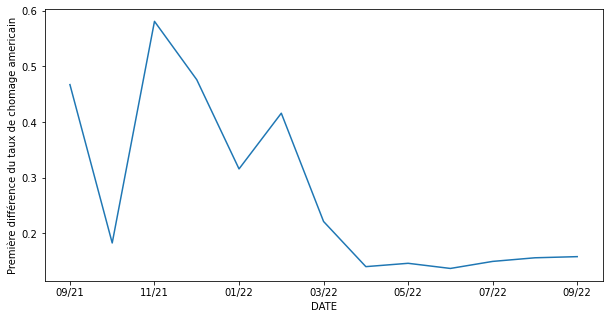

In [44]:
AR_withcovid = prediction_withcovidS.plot(figsize=(10,5),xlabel='DATE',ylabel="Première différence du taux de chomage americain")

# Model facteur


In [45]:
from statsmodels.multivariate.pca import PCA

In [46]:
fredmd = pd.read_csv('FactorModel.csv')

In [49]:
fredmd

,Number,Variable,Adjustments


In [47]:
fredmd.rename(columns = {'sasdate':'DATE'}, inplace = True)
fredmd.set_index("DATE", inplace=True)

KeyError: "None of ['DATE'] are in the columns"

In [48]:
def transxf(x,tcode):

    n=x.size

    # Value close to zero 
    small=1e-6
    #Allocate output variable
    y=np.nan*np.ones(n);
    y1=np.nan*np.ones(n);
#  global result 
    if tcode==1: #  no transformation): x(t)
        y=x
        result=y
        
    elif tcode==2: # First difference: x(t)-x(t-1)
      
        y[2:n]=x[2:n]-x[1:n-1];
        result= y
        
    elif tcode==3:  #Second difference: (x(t)-x(t-1))-(x(t-1)-x(t-2))
      
        y[3:n]=x[3:n]-2*x[2:n-1]+x[1:n-2]       
        result=y

    elif tcode==4:    #Natural log: ln(x)
      
        if min(x) < small:
            y=np.nan
        else :
            y=np.log(x)
              
            result=y
           
    elif tcode==5:   #First difference of natural log: ln(x)-ln(x-1)
            
        if  min(x[pd.notnull(x)]) > small:
            x=np.log(x)
            y[2:n]=x[2:n]-x[1:n-1]
            result=y
#          else:
#              result=x
            
    elif tcode==6:  #Second difference of natural log: (ln(x)-ln(x-1))-(ln(x-1)-ln(x-2))
         
        if  min(x[pd.notnull(x)]) > small:
            x=np.log(x)
            y[3:n]=x[3:n]-2*x[2:n-1]+x[1:n-2]
            result=y
        else:     
            result=x
    
    elif tcode==7 :  #First difference of percent change: (x(t)/x(t-1)-1)-(x(t-1)/x(t-2)-1)
        
        y1[2:n]=(x[2:n]-x[1:n-1])/x[1:n-1]
        y[3:n]=y1[3:n]-y1[2:n-1]
        result=y
      
    else:
        result=y
        
    return result           


yt=[]                #Initialize output variable                   
N=fredmd.shape[1]  #Number of series kept

for i in range(N):
    
    dum=transxf(fredmd.iloc[1:,i].values,fredmd.iloc[0,i])
    yt.append(dum)
    
trans_data=pd.DataFrame(yt).T
trans_data.columns=fredmd.columns
trans_data.index = fredmd.index[1:]
fredmd = trans_data.iloc[2:-1]
fredmd.index = pd.to_datetime(fredmd.index)
fredmd.index.freq = fredmd.index.inferred_freq

#fredmd = fredmd.shift(1)
fredmd = fredmd.iloc[22:] ## 10 avant

In [68]:
fredmd

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
DATE,,,,,,,,,,,,,,,,,,,,,
1961-01-01,0.008982,0.008686,0.002483,-0.036080,0.000780,0.001215,-0.001189,-0.002385,-0.008258,-0.037389,...,-0.001646,-0.001260,0.004415,-0.003724,-0.004640,NaN,-0.009943,-0.016002,-0.001037,NaN
1961-02-01,0.003817,0.000083,0.003686,0.012134,-0.003571,-0.001215,0.001189,0.000000,0.005905,-0.005460,...,0.000713,0.001594,-0.000019,-0.003683,0.000000,NaN,0.001268,0.001059,-0.010863,NaN
1961-03-01,0.004064,0.004912,0.012333,0.023524,0.010510,0.006065,0.004742,0.001193,0.000000,0.000006,...,-0.002634,-0.001175,-0.004396,0.007326,0.000000,NaN,0.001204,-0.001567,-0.010809,NaN
1961-04-01,0.002170,0.003453,0.000488,-0.029094,-0.017860,0.020348,0.015268,0.016547,0.023285,0.069991,...,-0.002430,0.001758,0.004376,-0.000053,0.009217,NaN,0.006111,0.005728,0.007390,NaN
1961-05-01,0.007748,0.005932,0.006053,0.028427,0.014924,0.015284,0.006969,0.008174,0.011441,0.031390,...,0.003687,-0.000839,-0.000019,-0.003656,-0.004640,NaN,0.003937,0.001458,0.007509,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-01,-0.152394,0.000453,0.004273,-0.003919,0.008998,0.000689,-0.006716,-0.008300,-0.005042,-0.028924,...,-0.004903,-0.000601,0.000721,0.005604,0.002988,3.4,0.002086,0.000550,-0.003229,15.9924
2021-05-01,-0.026821,0.001040,-0.004792,-0.020754,-0.013824,0.006232,0.006009,0.008166,0.006653,0.023632,...,-0.001414,-0.000674,-0.002330,-0.008027,0.002099,-5.4,-0.004479,-0.006439,-0.000177,17.9421
2021-06-01,-0.003488,0.001618,0.005309,0.004279,0.008488,0.004889,-0.001673,-0.000942,-0.003311,-0.014578,...,0.004174,0.000559,0.001109,0.001298,-0.000046,2.6,-0.004254,-0.001327,-0.006056,14.8913


In [449]:
endogpca = fredmd.iloc[:803-155]
factors = PCA(endogpca, ncomp=2, missing='fill-em')

In [450]:
x = ardl_select_order(unrate.iloc[155:803],12,factors.factors,maxorder=12, causal=True)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [451]:
x.ar_lags

[1]

In [452]:
x.dl_lags

{'comp_0': [1, 2], 'comp_1': [1, 2, 3, 4, 5]}

In [453]:
x.bic

BIC
-550.435878           (1, {'comp_0': 2, 'comp_1': 5})
-549.503058           (1, {'comp_0': 2, 'comp_1': 4})
-546.123903           (2, {'comp_0': 2, 'comp_1': 5})
-545.588247           (1, {'comp_0': 2, 'comp_1': 6})
-544.638924           (2, {'comp_0': 2, 'comp_1': 4})
                                ...                  
-367.399654       (1, {'comp_0': None, 'comp_1': 11})
-367.278017        (1, {'comp_0': None, 'comp_1': 9})
-366.774117     (None, {'comp_0': None, 'comp_1': 9})
-363.787323    (None, {'comp_0': None, 'comp_1': 12})
-362.176278       (1, {'comp_0': None, 'comp_1': 12})
Name: BIC, Length: 2197, dtype: object

In [454]:
## best bic cest 2 comp, mais just 2 lag des 5 premiere

In [69]:
res = []
prediction=[]
resindex = 0

k = 2

for h in range(12):
    print(h+1)
    for i in range(61):

        endog = unrate.iloc[155:803+i]
        
        
        #endogpca = fredmd.iloc[12-h:803-155+12+i-h+1]
        endogpca = fredmd.iloc[:803-155+i+1]
        
        
        factors = PCA(endogpca, ncomp=k, missing='fill-em')
        
        exog = factors.factors.iloc[:-1]
        
        
        exog.index=endog.index
        
        #model = AutoReg(endog, lags =[h+1], exog=exog)
        model = ARDL(endog, lags =[h+1], exog=exog, order={'comp_0':2,"comp_1":5},causal=True)
        
        v = model.fit()

        res.append(v)
        
        exog_oos = factors.factors.iloc[-1:]
        exog_oos.index = unrate.iloc[803+i:803+i+1].index
        
        
        prediction.append(res[resindex].predict(803+i-155,803+i-155,exog_oos=exog_oos))
        
        resindex +=1

1
2
3
4
5
6
7
8
9
10
11
12


In [70]:
mse_facteurmodel = [mean_squared_error(testset,prediction[i*61:(i*61)+61]) for i in range(12)]
mse_facteurmodel

[0.01606808791585316,
 0.016848917138138738,
 0.0168845182157144,
 0.016400680445471227,
 0.01695485902099726,
 0.016547018819337934,
 0.016942802198437686,
 0.017099774901185957,
 0.016866531062564253,
 0.017220824980740197,
 0.016646242381196615,
 0.0167121264190641]

In [71]:
mse_facteurmodel_relative = [i/mse_benchmark for i in mse_facteurmodel]
mse_facteurmodel_relative

[0.9381589491559903,
 0.9837488119004545,
 0.9858274331839645,
 0.957577853242006,
 0.9899343845718671,
 0.9661220344642493,
 0.9892304292511167,
 0.9983955114082288,
 0.9847772267881556,
 1.005463198367908,
 0.9719153480814228,
 0.9757620845478651]

In [91]:
mse_HAdf = pd.DataFrame()
mse_HAdf['MSE Factor model /MSE Benchmark'] =mse_facteurmodel_relative
mse_HAdf.index = hlist
mse_HAdf.index.names = ['h']
mse_HAdf

,MSE Factor model /MSE Benchmark
h,
1,0.938159
2,0.983749
3,0.985827
4,0.957578
5,0.989934
6,0.966122
7,0.989230
8,0.998396
9,0.984777


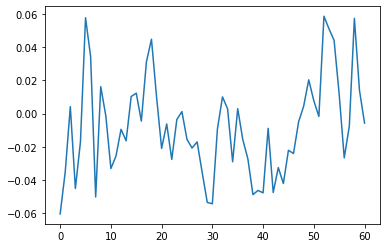

In [458]:
plt.plot(prediction[61*3:61*4])

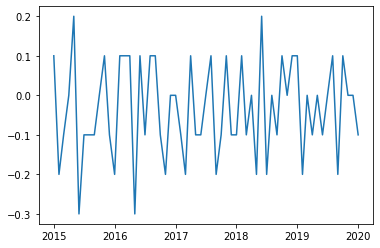

In [459]:
plt.plot(testset)

In [460]:
endogpca = fredmd
factors = PCA(endogpca, ncomp=2, missing='fill-em')

select_order_comp0 = sm.tsa.stattools.arma_order_select_ic(factors.factors["comp_0"], max_ar=6, max_ma =6)
select_order_comp1 = sm.tsa.stattools.arma_order_select_ic(factors.factors["comp_1"], max_ar=6, max_ma =6)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.8/s

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: N

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximu

In [461]:
print(select_order_comp0)
print(select_order_comp1)

{'bic':              0            1            2            3            4  \
0 -2718.584043 -2781.423261 -2774.845935 -2769.023565 -2764.102781   
1 -2775.723259 -2774.848718 -2768.249473 -2774.929972 -2761.067518   
2 -2772.588559 -2768.766953 -2772.470632 -2765.044848 -2750.342087   
3 -2771.793010 -2776.413502 -2766.520999 -2755.213594 -2751.970302   
4 -2767.367050 -2759.957481 -2763.268811 -2753.873407 -2745.506310   
5 -2764.775537 -2764.228139 -2756.854416 -2750.183954 -2742.393938   
6 -2760.349240 -2753.788542 -2751.218910 -2744.020537 -2737.642498   

             5            6  
0 -2760.403442 -2755.988415  
1 -2764.678164 -2758.441517  
2 -2757.395462 -2751.936335  
3 -2750.786957 -2744.883701  
4 -2745.692720 -2738.268693  
5 -2738.346434 -2732.609995  
6 -2731.644895 -2725.897682  , 'bic_min_order': (0, 1)}
{'bic':              0            1            2            3            4  \
0 -2718.584043 -2780.227144 -2783.842664 -2784.178311 -2801.106185   
1 -2796.817768 -2

In [120]:
fredmd_nocovid = fredmd.drop(labels=fredmd.index[864-155:881-155])

In [121]:
k=2

prediction_withcovid=[]
prediction_nocovid=[]

endogpca = fredmd
endogpca2 = fredmd_nocovid

factors = PCA(endogpca, ncomp=k, missing='fill-em')
factors2 = PCA(endogpca2, ncomp=k, missing='fill-em')

modelpca_comp_0 = ARIMA(factors.factors['comp_0'], order=(0,0,1))
modelpca_comp_1 = ARIMA(factors.factors['comp_1'], order=(1,0,1))
modelpca2_comp_0 = ARIMA(factors2.factors['comp_0'], order=(0,0,1))
modelpca2_comp_1 = ARIMA(factors2.factors['comp_1'], order=(1,0,1))

res_comp_0 = modelpca_comp_0.fit()
res_comp_1 = modelpca_comp_1.fit()
res2_comp_0 = modelpca2_comp_0.fit()
res2_comp_1 = modelpca2_comp_1.fit()

oos_exog_comp_0 = res_comp_0.predict(728,728+12,dynamic=True)
oos_exog_comp_1 = res_comp_1.predict(728,728+12,dynamic=True)
oos_exog2_comp_0 = res2_comp_0.predict(711,711+12,dynamic=True)
oos_exog2_comp_1 = res2_comp_1.predict(711,711+12,dynamic=True)

exog_oos = pd.concat([oos_exog_comp_0,oos_exog_comp_1],axis=1)
exog_oos2 = pd.concat([oos_exog2_comp_0,oos_exog2_comp_1],axis=1)

exog_oos.columns = ["comp_0",  "comp_1"]
exog_oos2.columns = ["comp_0",  "comp_1"]

endog = unrate.iloc[155:]
endog2 = unrate_nocovid.iloc[155:]


model = ARDL(endog, lags =[1], exog=factors.factors, order={'comp_0':2,"comp_1":5},causal=True)
model2 = ARDL(endog2, lags =[1], exog=factors2.factors, order={'comp_0':2,"comp_1":5},causal=True)

pred = model.fit()
pred2 = model2.fit()

predwcovid = pred.predict(728,728+12,dynamic=True,exog_oos=exog_oos)
prednocovid = pred2.predict(711,711+12,dynamic=True,exog_oos=exog_oos2)
prednocovid.index = predwcovid.index

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency informa

In [122]:
pred2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:             UNRATE_CHG   No. Observations:                  711
Model:                  ARDL(1, 2, 5)   Log Likelihood                 336.613
Method:               Conditional MLE   S.D. of innovations              0.151
Date:                Sun, 24 Oct 2021   AIC                           -653.227
Time:                        12:26:37   BIC                           -607.574
Sample:                             5   HQIC                          -635.591
                                  711                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0075      0.006     -1.314      0.189      -0.019       0.004
UNRATE_CHG.L1    -0.2069      0.040     -5.144      0.000      -0.286      -0.128
comp_0.L1         1.9292      0.240      8.047      0.000       1.459       2.400
comp_0.L2         0.9144      0.220      4.151      0.000       0.482       1.347
comp_1.L1        -0.2797      0.156     -1.798      0.073      -0.585       0.026
comp_1.L2        -0.2807      0.156     -1.802      0.072      -0.587       0.025
comp_1.L3        -0.4902      0.155     -3.161      0.002      -0.795      -0.186
comp_1.L4        -0.6505      0.155     -4.205      0.000      -0.954      -0.347
comp_1.L5        -0.5313      0.156     -3.407      0.001      -0.838      -0.225
=================================================================================
"""

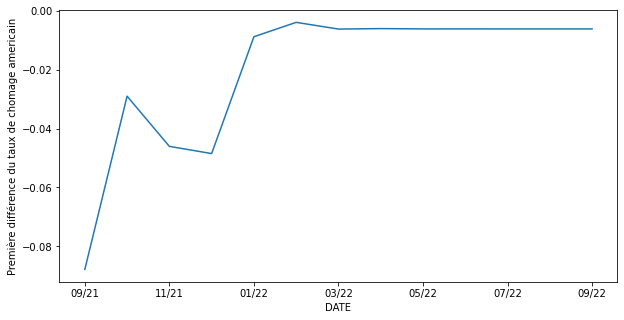

In [127]:
prediction_index = ['09/21','10/21','11/21','12/21','01/22','02/22','03/22','04/22','05/22',
                    '06/22','07/22','08/22','09/22']


prediction_withcovidS = pd.Series(predwcovid)
prediction_nocovidS = pd.Series(prednocovid)

prediction_withcovidS.index = prediction_index
prediction_nocovidS.index = prediction_index


AR_nocovid = prediction_nocovidS.plot(figsize=(10,5),xlabel='DATE',ylabel="Première différence du taux de chomage americain")

In [124]:
pred.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:             UNRATE_CHG   No. Observations:                  728
Model:                  ARDL(1, 2, 5)   Log Likelihood                -360.955
Method:               Conditional MLE   S.D. of innovations              0.398
Date:                Sun, 24 Oct 2021   AIC                            741.909
Time:                        12:26:37   BIC                            787.798
Sample:                    06-01-1961   HQIC                           759.617
                         - 08-01-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0042      0.015     -0.279      0.781      -0.033       0.025
UNRATE_CHG.L1    -0.6726      0.065    -10.279      0.000      -0.801      -0.544
comp_0.L1        -9.9390      0.795    -12.507      0.000     -11.499      -8.379
comp_0.L2         0.4550      0.460      0.989      0.323      -0.449       1.359
comp_1.L1        -1.4856      0.486     -3.059      0.002      -2.439      -0.532
comp_1.L2        -0.3948      0.455     -0.868      0.386      -1.288       0.499
comp_1.L3        -0.6069      0.452     -1.342      0.180      -1.495       0.281
comp_1.L4        -0.4732      0.451     -1.050      0.294      -1.358       0.412
comp_1.L5         0.0506      0.447      0.113      0.910      -0.827       0.928
=================================================================================
"""

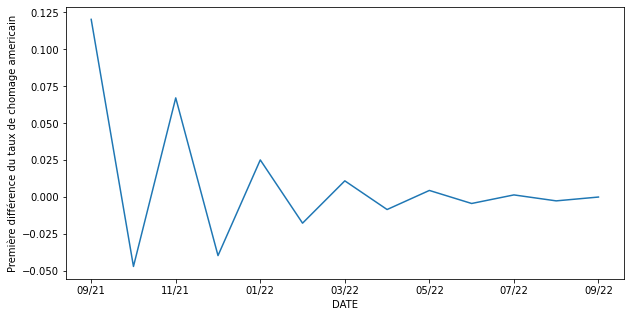

In [126]:
AR_withcovid = prediction_withcovidS.plot(figsize=(10,5),xlabel='DATE',ylabel="Première différence du taux de chomage americain")

## ARMA

In [468]:
from statsmodels.tsa.stattools import arma_order_select_ic as selectorderarma

sm.tsa.stattools.arma_order_select_ic(unrate.iloc[155:803], max_ar=6, max_ma =6)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.8/s

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/states

{'bic':             0           1           2           3           4           5  \
 0 -391.080290 -393.013459 -416.487714 -426.324568 -438.730914 -442.543410   
 1 -397.179444 -454.812899 -470.897178 -465.389663 -459.908086 -453.513729   
 2 -435.501170 -468.047049 -465.936518 -464.917099 -453.320691 -446.992861   
 3 -453.177377 -463.534431 -461.835035 -459.064668 -456.956290 -448.111349   
 4 -461.250333 -458.827441 -455.556930 -454.356310 -444.087692 -437.279338   
 5 -458.619027 -452.714509 -446.605975 -442.609927 -436.883068 -428.474805   
 6 -453.344255 -447.664440 -449.682543 -438.525840 -438.828916 -437.260376   
 
             6  
 0 -440.998542  
 1 -447.421844  
 2 -447.857250  
 3 -447.025973  
 4 -442.576779  
 5 -436.329691  
 6 -429.770759  ,
 'bic_min_order': (1, 2)}

In [73]:
res = []
prediction=[]
resindex = 0

for h in range(12):
    print(h+1)
    for i in range(61):

        endog = unrate.iloc[155:803+i] 
        
        
        model = ARIMA(endog, order=([h+1],0,2))

        v = model.fit()

        res.append(v)
        
        prediction.append(res[resindex].predict(803+i-155,803+i-155))
        
        resindex +=1

1


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2
3
4


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7
8
9
10
11
12


In [74]:
mse_ARMA = [mean_squared_error(testset,prediction[i*61:(i*61)+61]) for i in range(12)]
mse_ARMA

[0.01584953456486557,
 0.01612973037524053,
 0.01747287810368468,
 0.01543690433716505,
 0.017412305348985593,
 0.016126117148964413,
 0.016550778379436196,
 0.018065085164330814,
 0.017102358837793808,
 0.016191975741156057,
 0.016505209112690617,
 0.016405711801781263]

In [75]:
mse_ARMA_relative = [i/mse_benchmark for i in mse_ARMA]
mse_ARMA_relative

[0.9253983902661711,
 0.941758034823501,
 1.020179690721661,
 0.9013063674420003,
 1.0166430613359134,
 0.9415470712923069,
 0.9663415419109066,
 1.0547565710952356,
 0.998546378348054,
 0.9453923220755346,
 0.9636809132394849,
 0.9578716163813024]

In [77]:
mse_HAdf = pd.DataFrame()
mse_HAdf['MSE ARMA /MSE Benchmark'] =mse_ARMA_relative
mse_HAdf.index = hlist
mse_HAdf.index.names = ['h']
mse_HAdf

,MSE ARMA /MSE Benchmark
h,
1,0.925398
2,0.941758
3,1.020180
4,0.901306
5,1.016643
6,0.941547
7,0.966342
8,1.054757
9,0.998546


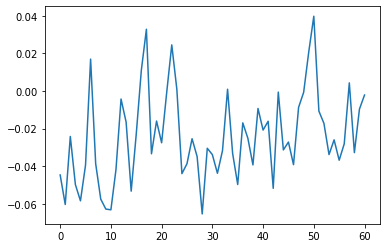

In [472]:
plt.plot(prediction[0:61])

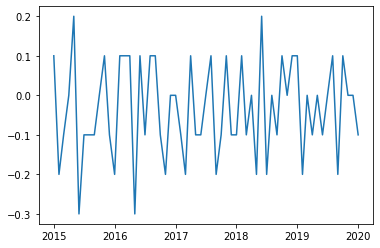

In [473]:
plt.plot(testset)

In [134]:
prediction_withcovid=[]
prediction_nocovid=[]

endog = unrate.iloc[155:]
endog2 = unrate_nocovid.iloc[155:]



model = ARIMA(endog, order=(1,0,2))
model2 = ARIMA(endog2, order=(1,0,2))

pred = model.fit()
pred2 = model2.fit()

predwcovid = pred.predict(728,728+12,dynamic=True)
prednocovid = pred2.predict(711,711+12,dynamic=True)
prednocovid.index = predwcovid.index

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction resul

In [135]:
pred2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             UNRATE_CHG   No. Observations:                  711
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 284.560
Date:                Sun, 24 Oct 2021   AIC                           -559.119
Time:                        12:32:26   BIC                           -536.286
Sample:                             0   HQIC                          -550.299
                                - 711                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0062      0.016     -0.390      0.696      -0.037       0.025
ar.L1          0.8716      0.034     26.012      0.000       0.806       0.937
ma.L1         -0.8735      0.043    -20.541      0.000      -0.957      -0.790
ma.L2          0.1987      0.039      5.086      0.000       0.122       0.275
sigma2         0.0263      0.001     23.140      0.000       0.024       0.029
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                50.63
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

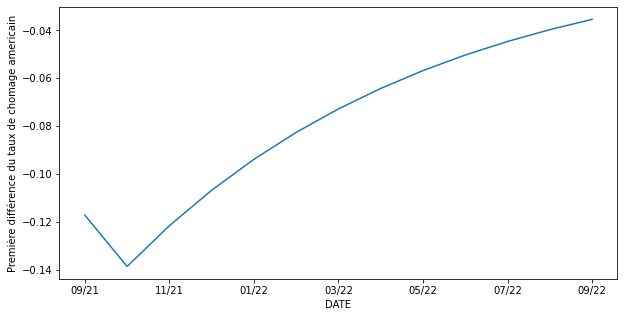

In [136]:
prediction_index = ['09/21','10/21','11/21','12/21','01/22','02/22','03/22','04/22','05/22',
                    '06/22','07/22','08/22','09/22']


prediction_withcovidS = pd.Series(predwcovid)
prediction_nocovidS = pd.Series(prednocovid)

prediction_withcovidS.index = prediction_index
prediction_nocovidS.index = prediction_index


ARMA_nocovid = prediction_nocovidS.plot(figsize=(10,5),xlabel='DATE',ylabel="Première différence du taux de chomage americain")

In [137]:
pred.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             UNRATE_CHG   No. Observations:                  728
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -437.331
Date:                Sun, 24 Oct 2021   AIC                            884.661
Time:                        12:32:26   BIC                            907.613
Sample:                    01-01-1961   HQIC                           893.517
                         - 08-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.033     -0.053      0.958      -0.066       0.063
ar.L1          0.6218      0.126      4.936      0.000       0.375       0.869
ma.L1         -0.5872      0.128     -4.585      0.000      -0.838      -0.336
ma.L2         -0.0997      0.015     -6.781      0.000      -0.128      -0.071
sigma2         0.1947      0.002    121.479      0.000       0.192       0.198
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           5298474.66
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              13.09   Skew:                            17.64
Prob(H) (two-sided):                  0.00   Kurtosis:                       419.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

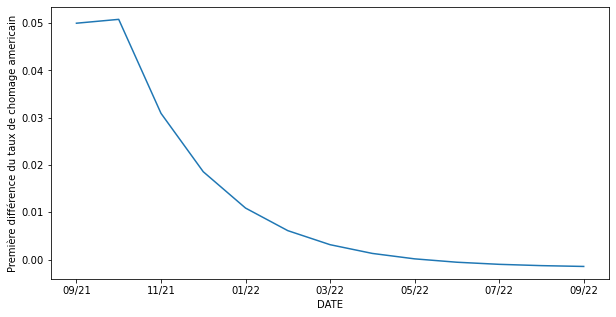

In [138]:
ARMA_withcovid = prediction_withcovidS.plot(figsize=(10,5),xlabel='DATE',ylabel="Première différence du taux de chomage americain")

## ARDL

In [479]:
x = ardl_select_order(unrate.iloc[155:803],12,fredmd.iloc[:803-155,30:32],maxorder=12, causal=True)

In [480]:
x.ar_lags

[1]

In [481]:
x.dl_lags

{'CLAIMSx': [1, 2, 3], 'PAYEMS': [1, 2]}

In [78]:
res = []
prediction=[]
resindex = 0

k = 2

for h in range(12):
    print(h+1)
    for i in range(61):

        endog = unrate.iloc[155:803+i]
        
        exog = fredmd.iloc[:803-155+i+1,30:32]
        exog_oos = exog.iloc[-1:]
        exog = exog.iloc[:-1]
        
        
        exog.index=endog.index
        
        #model = AutoReg(endog, lags =[h+1], exog=exog)
        model = ARDL(endog, lags =[h+1], exog=exog, order={'CLAIMSx':3,"PAYEMS":2},causal=True)
        
        v = model.fit()

        res.append(v)
        
        exog_oos.index = unrate.iloc[803+i:803+i+1].index
        
        
        prediction.append(res[resindex].predict(803+i-155,803+i-155,exog_oos=exog_oos))
        
        resindex +=1

1
2
3
4
5
6
7
8
9
10
11
12


In [79]:
prediction

[2015-01-01   -0.005943
 Freq: MS, dtype: float64,
 2015-02-01   -0.026116
 Freq: MS, dtype: float64,
 2015-03-01    0.065398
 Freq: MS, dtype: float64,
 2015-04-01    0.015672
 Freq: MS, dtype: float64,
 2015-05-01   -0.001728
 Freq: MS, dtype: float64,
 2015-06-01   -0.131785
 Freq: MS, dtype: float64,
 2015-07-01    0.028982
 Freq: MS, dtype: float64,
 2015-08-01   -0.00178
 Freq: MS, dtype: float64,
 2015-09-01    0.020502
 Freq: MS, dtype: float64,
 2015-10-01    0.020869
 Freq: MS, dtype: float64,
 2015-11-01   -0.034609
 Freq: MS, dtype: float64,
 2015-12-01   -0.048675
 Freq: MS, dtype: float64,
 2016-01-01    0.012505
 Freq: MS, dtype: float64,
 2016-02-01    0.080737
 Freq: MS, dtype: float64,
 2016-03-01   -0.026849
 Freq: MS, dtype: float64,
 2016-04-01   -0.047435
 Freq: MS, dtype: float64,
 2016-05-01   -0.046377
 Freq: MS, dtype: float64,
 2016-06-01    0.110081
 Freq: MS, dtype: float64,
 2016-07-01   -0.013524
 Freq: MS, dtype: float64,
 2016-08-01   -0.031684
 Freq: M

In [80]:
mse_ARDL = [mean_squared_error(testset,prediction[i*61:(i*61)+61]) for i in range(12)]
mse_ARDL

[0.014849456864607003,
 0.015476483648768245,
 0.015578581172071332,
 0.014885673371294955,
 0.015594207655941491,
 0.015034116746823927,
 0.015408880745284764,
 0.015914025388549188,
 0.015599816966472394,
 0.015678903692783068,
 0.015002051246762883,
 0.015374480731444701]

In [81]:
mse_ARDL_relative = [i/mse_benchmark for i in mse_ARDL]
mse_ARDL_relative

[0.8670073826203121,
 0.903617263771198,
 0.9095783778549063,
 0.8691219366378407,
 0.9104907531022539,
 0.8777890214785968,
 0.8996701688073111,
 0.9291637818730675,
 0.9108182609489075,
 0.9154358558012861,
 0.8759168300891192,
 0.897661673396771]

In [82]:
mse_HAdf = pd.DataFrame()
mse_HAdf['MSE ARDL /MSE Benchmark'] =mse_ARDL_relative
mse_HAdf.index = hlist
mse_HAdf.index.names = ['h']
mse_HAdf

,MSE ARDL /MSE Benchmark
h,
1,0.867007
2,0.903617
3,0.909578
4,0.869122
5,0.910491
6,0.877789
7,0.899670
8,0.929164
9,0.910818


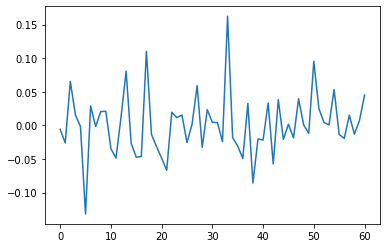

In [486]:
plt.plot(prediction[:61])

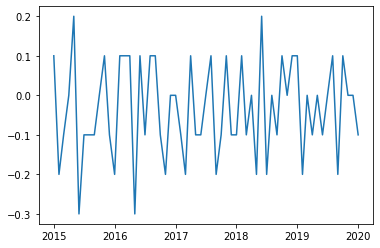

In [487]:
plt.plot(testset)

In [525]:
select_order_claims = sm.tsa.stattools.arma_order_select_ic(fredmd.iloc[:,30], max_ar=6, max_ma =6)
select_order_payems = sm.tsa.stattools.arma_order_select_ic(fredmd.iloc[:,31], max_ar=6, max_ma =6)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximu

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/b

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [489]:
select_order_claims

{'bic':              0            1            2            3            4  \
 0 -1119.496233 -1156.978908 -1176.273876 -1179.418231 -1173.628228   
 1 -1136.811278 -1164.028767 -1180.524134 -1177.760505 -1171.149551   
 2 -1178.717846 -1174.703945 -1180.589682 -1171.177841 -1176.754141   
 3 -1173.782311 -1168.135209 -1172.879650 -1183.035153 -1173.461281   
 4 -1172.233082 -1182.833639 -1168.035338 -1175.423467 -1159.700453   
 5 -1172.657865 -1168.593744 -1162.453508 -1166.871958 -1155.254257   
 6 -1166.361897 -1162.020174 -1161.093467 -1161.180347 -1149.275495   
 
              5            6  
 0 -1179.490969 -1173.018914  
 1 -1173.148048 -1173.344382  
 2 -1166.968493 -1165.752457  
 3 -1168.273039 -1164.303821  
 4 -1155.048875 -1149.387611  
 5 -1149.667685 -1144.262773  
 6 -1142.977408 -1145.036871  ,
 'bic_min_order': (3, 3)}

In [490]:
select_order_payems

{'bic':              0            1            2            3            4  \
 0 -5340.711954 -5338.709680 -5340.735252 -5334.101543 -5327.430849   
 1 -5337.741564 -5336.873552 -5334.130180 -5314.351780 -5315.522578   
 2 -5340.564380 -5334.141569 -5327.591094 -5320.991697 -5314.318660   
 3 -5334.123833 -5327.538012 -5320.976553 -5314.421872 -5307.712548   
 4 -5327.542825 -5320.961442 -5314.395493 -5307.818762 -5301.205666   
 5 -5321.789970 -5315.151123 -5308.658096 -5302.036915 -5295.450363   
 6 -5315.565583 -5308.918555 -5302.561996 -5295.988182 -5289.397139   
 
              5            6  
 0 -5321.781427 -5316.113820  
 1 -5320.016779 -5314.709466  
 2 -5312.895492 -5308.107718  
 3 -5182.821251 -5301.787911  
 4 -5294.977356 -5295.607930  
 5 -5294.423340 -5289.830407  
 6 -5287.274434 -5282.235855  ,
 'bic_min_order': (0, 2)}

In [144]:
prediction_withcovid=[]
prediction_nocovid=[]

endog = unrate.iloc[155:]
endog2 = unrate_nocovid.iloc[155:]


model_claims = ARIMA(fredmd.iloc[:,30], order=(3,0,3))
model_payems = ARIMA(fredmd.iloc[:,31], order=(0,0,2))
model2_claims = ARIMA(fredmd.iloc[:,30], order=(3,0,3))
model2_payems = ARIMA(fredmd.iloc[:,31], order=(0,0,2))

res_claims = model_claims.fit()
res_payems = model_payems.fit()
res2_claims = model2_claims.fit()
res2_payems = model2_payems.fit()

oos_exog_claims = res_claims.predict(728,728+12,dynamic=True)
oos_exog_payems = res_payems.predict(728,728+12,dynamic=True)
oos_exog2_claims = res2_claims.predict(711,711+12,dynamic=True)
oos_exog2_payems = res2_payems.predict(711,711+12,dynamic=True)

exog_oos= pd.concat([oos_exog_claims,oos_exog_payems],axis=1)
exog_oos2= pd.concat([oos_exog2_claims,oos_exog2_payems],axis=1)


exog_oos.columns = ["CLAIMSx",  "PAYEMS"]
exog_oos2.columns = ["CLAIMSx",  "PAYEMS"]

model = ARDL(endog, lags =[1], exog=fredmd.iloc[:,30:32], order={'CLAIMSx':3,"PAYEMS":2},causal=True)
model2 = ARDL(endog2, lags =[1], exog=fredmd_nocovid.iloc[:,30:32], order={'CLAIMSx':3,"PAYEMS":2},causal=True)

pred = model.fit()
pred2 = model2.fit()

predwcovid = pred.predict(728,728+12,dynamic=True,exog_oos=exog_oos)
prednocovid = pred2.predict(711,711+12,dynamic=True, exog_oos=exog_oos2)
prednocovid.index = predwcovid.index

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/opt/ana

In [145]:
pred2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:             UNRATE_CHG   No. Observations:                  711
Model:                  ARDL(1, 3, 2)   Log Likelihood                 347.366
Method:               Conditional MLE   S.D. of innovations              0.148
Date:                Sun, 24 Oct 2021   AIC                           -678.733
Time:                        12:47:58   BIC                           -642.211
Sample:                             3   HQIC                          -664.624
                                  711                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0500      0.008      6.478      0.000       0.035       0.065
UNRATE_CHG.L1    -0.1946      0.038     -5.091      0.000      -0.270      -0.120
CLAIMSx.L1        0.8284      0.128      6.497      0.000       0.578       1.079
CLAIMSx.L2        0.5942      0.125      4.749      0.000       0.349       0.840
CLAIMSx.L3        0.5306      0.123      4.305      0.000       0.289       0.772
PAYEMS.L1       -20.9768      3.703     -5.665      0.000     -28.246     -13.707
PAYEMS.L2       -16.2893      3.573     -4.559      0.000     -23.305      -9.274
=================================================================================
"""

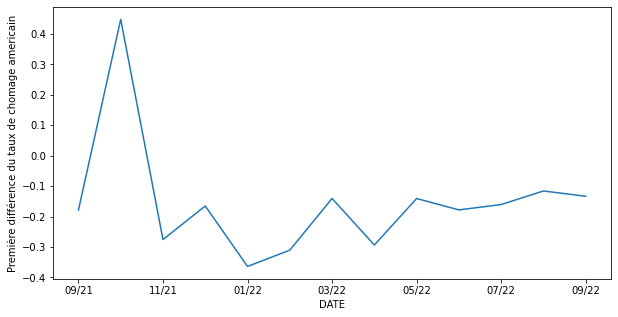

In [146]:
prediction_index = ['09/21','10/21','11/21','12/21','01/22','02/22','03/22','04/22','05/22',
                    '06/22','07/22','08/22','09/22']


prediction_withcovidS = pd.Series(predwcovid)
prediction_nocovidS = pd.Series(prednocovid)

prediction_withcovidS.index = prediction_index
prediction_nocovidS.index = prediction_index


ARDL_nocovid = prediction_nocovidS.plot(figsize=(10,5),xlabel='DATE',ylabel="Première différence du taux de chomage americain")

In [147]:
pred.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:             UNRATE_CHG   No. Observations:                  728
Model:                  ARDL(1, 3, 2)   Log Likelihood                  -2.419
Method:               Conditional MLE   S.D. of innovations              0.243
Date:                Sun, 24 Oct 2021   AIC                             20.838
Time:                        12:47:58   BIC                             57.550
Sample:                    04-01-1961   HQIC                            35.005
                         - 08-01-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0047      0.011      0.410      0.682      -0.018       0.027
UNRATE_CHG.L1    -0.2954      0.055     -5.418      0.000      -0.402      -0.188
CLAIMSx.L1        3.6921      0.092     40.059      0.000       3.511       3.873
CLAIMSx.L2       -0.0183      0.170     -0.108      0.914      -0.352       0.316
CLAIMSx.L3        0.0530      0.141      0.375      0.708      -0.225       0.331
PAYEMS.L1         1.7781      4.164      0.427      0.670      -6.398       9.954
PAYEMS.L2        -6.9812      2.829     -2.468      0.014     -12.534      -1.428
=================================================================================
"""

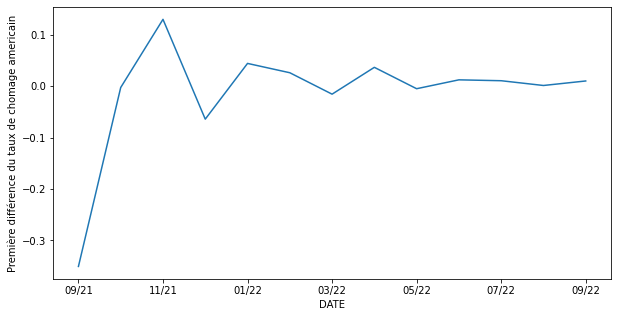

In [148]:
ARDL_withcovid = prediction_withcovidS.plot(figsize=(10,5),xlabel='DATE',ylabel="Première différence du taux de chomage americain")

## HOLTZZZ

In [507]:
from statsmodels.tsa.api import ExponentialSmoothing

In [508]:
res = []
prediction=[]
resindex = 0

for h in range(12):
    for i in range(61):

        endog = unrate.iloc[155:803+i] 
        
        
        model = ExponentialSmoothing(endog,'add')

        v = model.fit()

        res.append(v)
        
        prediction.append(res[resindex].predict(803+i-155,803+i-155))
        
        resindex +=1

In [509]:
prediction

[2015-01-01   -0.102499
 Freq: MS, dtype: float64,
 2015-02-01   -0.068331
 Freq: MS, dtype: float64,
 2015-03-01   -0.090793
 Freq: MS, dtype: float64,
 2015-04-01   -0.092508
 Freq: MS, dtype: float64,
 2015-05-01   -0.077026
 Freq: MS, dtype: float64,
 2015-06-01   -0.030155
 Freq: MS, dtype: float64,
 2015-07-01   -0.076021
 Freq: MS, dtype: float64,
 2015-08-01   -0.080173
 Freq: MS, dtype: float64,
 2015-09-01   -0.083635
 Freq: MS, dtype: float64,
 2015-10-01   -0.086523
 Freq: MS, dtype: float64,
 2015-11-01   -0.072164
 Freq: MS, dtype: float64,
 2015-12-01   -0.043413
 Freq: MS, dtype: float64,
 2016-01-01   -0.053012
 Freq: MS, dtype: float64,
 2016-02-01   -0.077716
 Freq: MS, dtype: float64,
 2016-03-01   -0.048166
 Freq: MS, dtype: float64,
 2016-04-01   -0.023416
 Freq: MS, dtype: float64,
 2016-05-01   -0.0026
 Freq: MS, dtype: float64,
 2016-06-01   -0.052547
 Freq: MS, dtype: float64,
 2016-07-01   -0.027341
 Freq: MS, dtype: float64,
 2016-08-01   -0.039449
 Freq: MS

In [510]:
mse_ES = [mean_squared_error(testset,prediction[i*61:(i*61)+61]) for i in range(12)]
mse_ES

[0.017356814636661902,
 0.017356814636661902,
 0.017356814636661902,
 0.017356814636661902,
 0.017356814636661902,
 0.017356814636661902,
 0.017356814636661902,
 0.017356814636661902,
 0.017356814636661902,
 0.017356814636661902,
 0.017356814636661902,
 0.017356814636661902]

In [511]:
mse_ES_relative = [i/mse_benchmark for i in mse_ES]
mse_ES_relative

[1.0134031544699478,
 1.0134031544699478,
 1.0134031544699478,
 1.0134031544699478,
 1.0134031544699478,
 1.0134031544699478,
 1.0134031544699478,
 1.0134031544699478,
 1.0134031544699478,
 1.0134031544699478,
 1.0134031544699478,
 1.0134031544699478]

## VAR

In [84]:
from statsmodels.tsa.api import VAR

In [85]:
res = []
prediction=[]
resindex = 0

for h in range(12):
    print(h+1)
    for i in range(61):
        endog = pd.concat([unrate.iloc[155:803+i],fredmd.iloc[:-155+803+i,30]],axis=1)
        x = VAR(endog)
        y = x.fit(maxlags=12,ic='bic')
        
        lag_order = y.k_ar
        prediction.append(y.forecast(endog.values[-lag_order:],h+1)[-1][0])

1
2
3
4
5
6
7
8
9
10
11
12


In [86]:
lag_order

6

In [87]:
prediction

[-0.045123791754044094,
 -0.08934408272339726,
 0.020211922490001727,
 -0.04124810056806674,
 -0.029325337544948763,
 -0.15900988197488997,
 -0.0012553194223348906,
 -0.03048147821814683,
 -0.008160228186555075,
 -0.030028858759711237,
 -0.07110852350931121,
 -0.10983371499135855,
 -0.014961200791490993,
 0.05192318142409879,
 -0.051278395454029416,
 -0.06309436153788389,
 -0.05884892734552838,
 0.06374410419753467,
 -0.025752111159295717,
 -0.0004985300532085197,
 -0.046251758714864734,
 -0.08770238946160795,
 -0.03728709768948894,
 -0.015037467634987069,
 -0.003105552295506825,
 -0.029464853070098187,
 -0.04990869211726989,
 -0.0005315373805333083,
 -0.08102937007963554,
 -0.020762206708630503,
 -0.04631623233136106,
 -0.02877163372828177,
 -0.05906229019548228,
 0.14383698206539042,
 -0.05286524220969897,
 -0.05896699623562379,
 -0.07685513686789973,
 -0.01854205360155836,
 -0.1342895109615637,
 -0.06387458129775822,
 -0.0458256031176104,
 -0.005356986010192397,
 -0.0749488935292163

In [88]:
mse_VAR = [mean_squared_error(testset,prediction[i*61:(i*61)+61]) for i in range(12)]
mse_VAR

[0.014078022844989758,
 0.017414895409280706,
 0.016814571649265083,
 0.017805555831147603,
 0.016122013670727103,
 0.01627980391994855,
 0.015304129574189413,
 0.016344501691365323,
 0.016002854911403377,
 0.015763727397318482,
 0.015561874604986127,
 0.015750089857843465]

In [89]:
mse_VAR_relative = [i/mse_benchmark for i in mse_VAR]
mse_VAR_relative

[0.8219660726040002,
 1.0167942858162275,
 0.9817435000102844,
 1.0396035692091745,
 0.9413074836791969,
 0.9505202994897579,
 0.8935541175937305,
 0.954297774044475,
 0.934350224233312,
 0.9203884125664222,
 0.9086029403602435,
 0.9195921647633261]

In [90]:
mse_HAdf = pd.DataFrame()
mse_HAdf['MSE VAR /MSE Benchmark'] =mse_VAR_relative
mse_HAdf.index = hlist
mse_HAdf.index.names = ['h']
mse_HAdf

,MSE VAR /MSE Benchmark
h,
1,0.821966
2,1.016794
3,0.981744
4,1.039604
5,0.941307
6,0.950520
7,0.893554
8,0.954298
9,0.934350


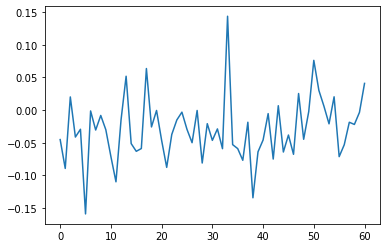

In [517]:
plt.plot(prediction[:61])

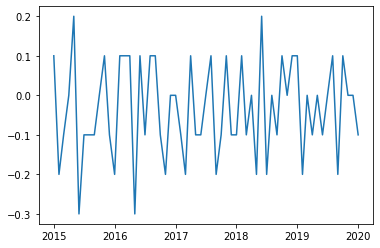

In [518]:
plt.plot(testset)

In [154]:
prediction_withcovid=[]
prediction_nocovid=[]

endog = pd.concat([unrate.iloc[155:],fredmd.iloc[:,30]],axis=1)
endog2 = pd.concat([unrate_nocovid.iloc[155:],fredmd_nocovid.iloc[:,30]],axis=1)

model = VAR(endog)
model2 = VAR(endog2)

pred = model.fit(maxlags=6)
pred2 = model2.fit(maxlags=6)
                   
lag_order = pred.k_ar

predwcovid = pred.forecast(endog.values[-lag_order:],13)
prednocovid = pred2.forecast(endog2.values[-lag_order:],13)

predwcovid = predwcovid.T[0]
prednocovid = prednocovid.T[0]


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [155]:
pred2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 24, Oct, 2021
Time:                     12:55:04
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -9.79573
Nobs:                     705.000    HQIC:                  -9.89887
Log likelihood:           1537.55    FPE:                4.70723e-05
AIC:                     -9.96384    Det(Omega_mle):     4.53831e-05
--------------------------------------------------------------------
Results for equation UNRATE_CHG
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.002173         0.005685           -0.382           0.702
L1.UNRATE_CHG        -0.170869         0.039137           -4.366           0.000
L1.CLAIMSx            1.073411         0.127034        

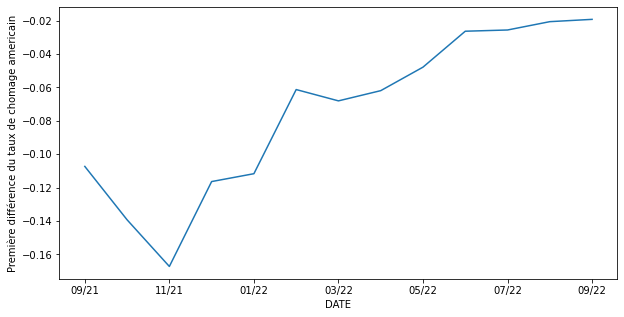

In [156]:
prediction_index = ['09/21','10/21','11/21','12/21','01/22','02/22','03/22','04/22','05/22',
                    '06/22','07/22','08/22','09/22']


prediction_withcovidS = pd.Series(predwcovid)
prediction_nocovidS = pd.Series(prednocovid)

prediction_withcovidS.index = prediction_index
prediction_nocovidS.index = prediction_index


VAR_nocovid = prediction_nocovidS.plot(figsize=(10,5),xlabel='DATE',ylabel="Première différence du taux de chomage americain")

In [157]:
pred.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 24, Oct, 2021
Time:                     12:55:04
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.27681
Nobs:                     722.000    HQIC:                  -7.37812
Log likelihood:           663.548    FPE:                0.000586225
AIC:                     -7.44181    Det(Omega_mle):     0.000565671
--------------------------------------------------------------------
Results for equation UNRATE_CHG
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.002612         0.008922           -0.293           0.770
L1.UNRATE_CHG        -0.315277         0.039697           -7.942           0.000
L1.CLAIMSx            3.708234         0.090336        

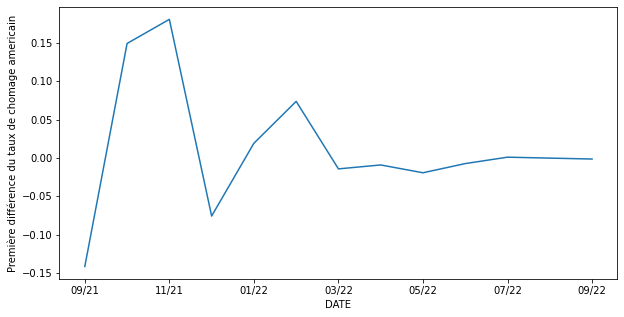

In [158]:
VAR_withcovid = prediction_withcovidS.plot(figsize=(10,5),xlabel='DATE',ylabel="Première différence du taux de chomage americain")